In [1]:
from interaction_inference import simulation, dataset
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import tqdm
import numpy as np

In [2]:
rng = np.random.default_rng()

# Dispersion

Assuming data follows a Poisson distribution assumes that $mean = variance$, if the data has $mean < variance$ it is 'overdispersed' and if $mean > variance$ it is 'underdispersed'

Non-poisson data is typically overdispersed, and we show that this is the case for interacting birth-death and telegraph data via simulations.

Unfortunately, moment optimization seems to remain feasible for overdispersed data, only becoming infeasible for underdispersed data, and again  show this is the case using simulated data.

Finally we investigate if higher moments (3rd, etc) can solve this issues, and detect interaction in overdispersed data.

# Interaction & Telegraph causes overdispersion

In [3]:
def custom_scatter(data, L, U, color, label):

    means = []
    variances = []

    for sample, moments in data.moments_OB.items():
        
        E_1 = np.mean(moments['E_x1'])
        E_2 = np.mean(moments['E_x2'])
        
        E_sq_1 = np.mean(moments['E_x1_sq'])
        E_sq_2 = np.mean(moments['E_x2_sq'])

        means.append(E_1)
        variances.append(E_sq_1 - E_1**2)

        means.append(E_2)
        variances.append(E_sq_2 - E_2**2)

    plt.scatter(means, variances, color=color, label=label)

    L = min(L, min(means), min(variances))
    U = max(U, max(means), max(variances))

    return L, U

In [4]:
samples = 10
intr = 5
rate = 5
data_BD_ind = simulation.simulate_dataset_range_BD("test", [0 for i in range(samples)], rate=rate, tqdm_disable=False)
data_BD_int = simulation.simulate_dataset_range_BD("test", [intr for i in range(samples)], rate=rate, tqdm_disable=False)
data_BD_ind.compute_moments()
data_BD_int.compute_moments()

100%|██████████| 10/10 [00:34<00:00,  3.40s/it]


In [5]:
b = 2
beta = rng.beta(1, b, size=1000)
data_BD_D_ind = data_BD_ind.downsample("test", beta)
data_BD_D_int = data_BD_int.downsample("test", beta)
data_BD_D_ind.compute_moments()
data_BD_D_int.compute_moments()

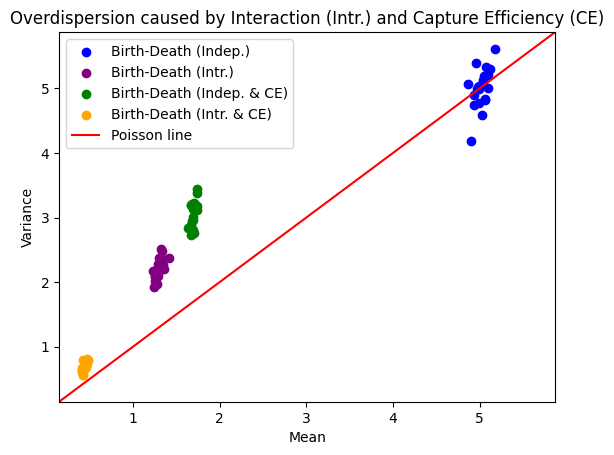

In [6]:
L = np.inf
U = 0
L, U = custom_scatter(data_BD_ind, L, U, "blue", "Birth-Death (Indep.)")
L, U = custom_scatter(data_BD_int, L, U, "purple", "Birth-Death (Intr.)")
L, U = custom_scatter(data_BD_D_ind, L, U, "green", "Birth-Death (Indep. & CE)")
L, U = custom_scatter(data_BD_D_int, L, U, "orange", "Birth-Death (Intr. & CE)")
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.title("Overdispersion caused by Interaction (Intr.) and Capture Efficiency (CE)")
plt.axline([L, L], [U, U], color="red", label="Poisson line")
plt.legend()

In [8]:
samples = 10
intr = 5
rate = 5
gene = 0.5
data_TE_ind = simulation.simulate_dataset_range_TE("test", [0 for i in range(samples)], rate=rate, gene=gene, tqdm_disable=False)
data_TE_int = simulation.simulate_dataset_range_TE("test", [intr for i in range(samples)], rate=rate, gene=gene, tqdm_disable=False)
data_TE_ind.compute_moments()
data_TE_int.compute_moments()

100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


In [9]:
b = 2
beta = rng.beta(1, b, size=1000)
data_TE_D_ind = data_TE_ind.downsample("test", beta)
data_TE_D_int = data_TE_int.downsample("test", beta)
data_TE_D_ind.compute_moments()
data_TE_D_int.compute_moments()

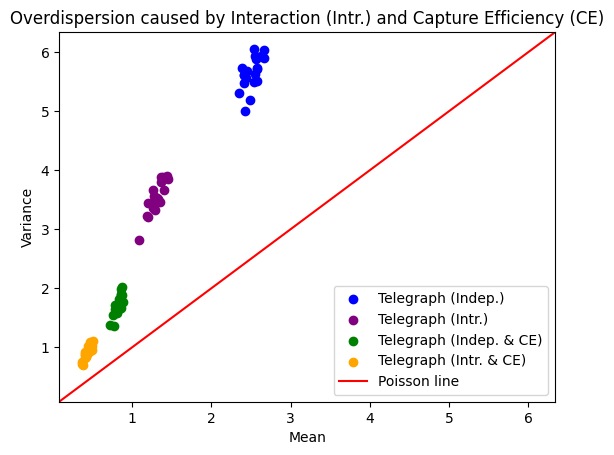

In [11]:
L = np.inf
U = 0
L, U = custom_scatter(data_TE_ind, L, U, "blue", "Telegraph (Indep.)")
L, U = custom_scatter(data_TE_int, L, U, "purple", "Telegraph (Intr.)")
L, U = custom_scatter(data_TE_D_ind, L, U, "green", "Telegraph (Indep. & CE)")
L, U = custom_scatter(data_TE_D_int, L, U, "orange", "Telegraph (Intr. & CE)")
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.title("Overdispersion caused by Interaction (Intr.) and Capture Efficiency (CE)")
plt.axline([L, L], [U, U], color="red", label="Poisson line")
plt.legend()

# Overdispersed feasible, Underdispersed infeasible

## Simulating over & under dispersion

Use a generalized poisson (*) distribution to sample data that is overdispersed $mean < variance$ and underdispersed $mean > var$

___

(*) Adjust (zero + normalize probabilities) so really a more general discetete distribution, but doesn't matter as just used for sampling

In [12]:
def generalised_poisson_pmf(x, lam, alp):
    t = (1 - alp)*lam + alp*x
    return (1 - alp)*lam * (t ** (x - 1)) * np.exp(-t) / scipy.special.factorial(x)

In [14]:
def sample_generalized_poisson(lam, alp, M, N=1000, normalize=True):

    # support
    s = np.arange(M, dtype=float)

    # 'probabilities' over support
    p = generalised_poisson_pmf(s, lam, alp)
    
    # remove negatives
    p[p < 0] = 0

    # normalize
    if normalize:
        p = p / sum(p)

    # sample
    sample = rng.choice(s, N, p=p)

    return sample

In [17]:
def plot_dispersion(lam, alp, M, N=1000, n=100, normalize=True):
    means = []
    variances = []
    for i in range(n):
        sample = sample_generalized_poisson(lam, alp, M, N, normalize)
        means.append(np.mean(sample))
        variances.append(np.var(sample))
    plt.scatter(means, variances)
    L = min(min(means), min(variances))
    U = max(max(means), max(variances))
    plt.axline([L, L], [U, U], color="red")
    plt.xlabel("Mean")
    plt.ylabel("Variance")
    plt.title("Dispersion")

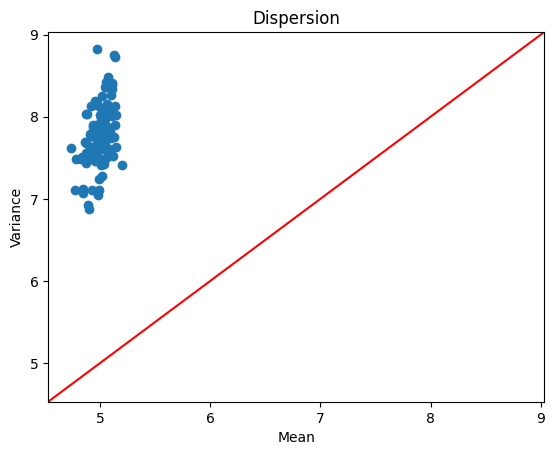

In [35]:
# overdispersion
plot_dispersion(5, 0.2, 20, 1000, 100, True)

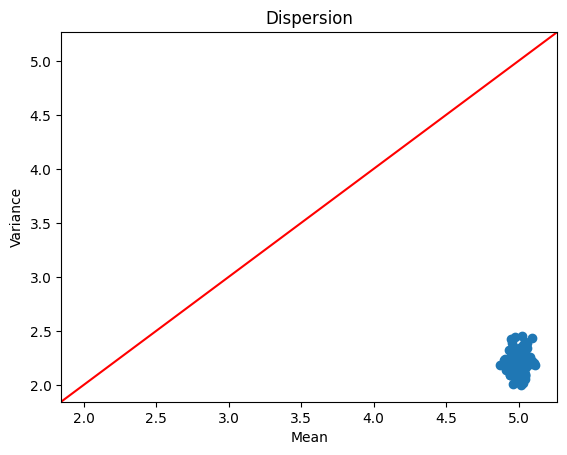

In [18]:
# underdispersion
plot_dispersion(5, -0.5, 20, 1000, 100, True)

## Moment optimization

Simulate a sample of over/under-dispersed data (*) and test birth-death model feasibility using moment intervals.

___

(*) pair with a sample of zeros as only testing 1st gene marginal for model, removing any interaction constraint impact

In [33]:
from interaction_inference import optimization

In [37]:
def construct_dispersed_dataset(lam, alp, M, normalize=True, cells=1000, genes=10):

    # support
    s = np.arange(M, dtype=float)

    # 'probabilities' over support
    p = generalised_poisson_pmf(s, lam, alp)
    
    # remove negatives
    p[p < 0] = 0

    # normalize
    if normalize:
        p = p / sum(p)

    # dataframes
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(genes)], columns=[f"Cell-{j}" for j in range(cells)])

    # fill
    for g in range(genes):

        # sample
        sample = rng.choice(s, cells, p=p)

        # zero other sample
        zeros = np.zeros(cells)

        # pair
        paired_sample = list(zip(sample, zeros))

        # store
        counts_df.iloc[g] = paired_sample

    # construct dataset object
    data = dataset.Dataset("Dispersion")

    # store information
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = genes
    data.beta = np.array([1.0 for j in range(cells)])

    # bootstrap
    data.compute_moments(tqdm_disable=True)
    data.compute_probabilities(display=False, tqdm_disable=True)
    data.compute_fm(tqdm_disable=True)

    return data

### Overdispersion

Moment optimization **feasible**

Probability optimization infeasible

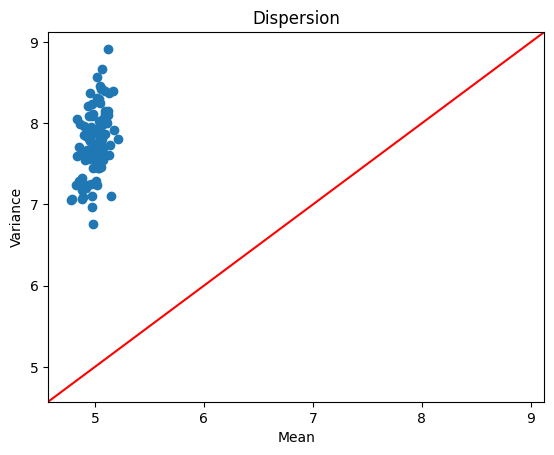

In [39]:
# settings
lam = 5
alp = 0.2
M = 20

# display
plot_dispersion(lam, alp, M, 1000, 100, True)

# sample
data = construct_dispersed_dataset(lam, alp, M, True, 1000, 5)

In [40]:
# optimize moments
constraints = [
    "moment",
    "higher_moment",
    "marginal_CME_1",
    "k_deg_1"
]

opt = optimization.Optimization(data, constraints, tqdm_disable=True)

Optimization status: OPTIMAL
Runtime: 0.04699993133544922
Optimization status: OPTIMAL
Runtime: 0.03600001335144043
Optimization status: OPTIMAL
Runtime: 0.023000001907348633
Optimization status: OPTIMAL
Runtime: 0.021000146865844727
Optimization status: OPTIMAL
Runtime: 0.0


In [41]:
# optimize probabilities
constraints = [
    "marginal_probability_1",
    "marginal_CME_1",
    "k_deg_1"
]

opt = optimization.Optimization(data, constraints, tqdm_disable=True)

Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.002000093460083008
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.01900005340576172


### Underdispersion

Moment optimization **infeasible**

Probability optimization infeasible

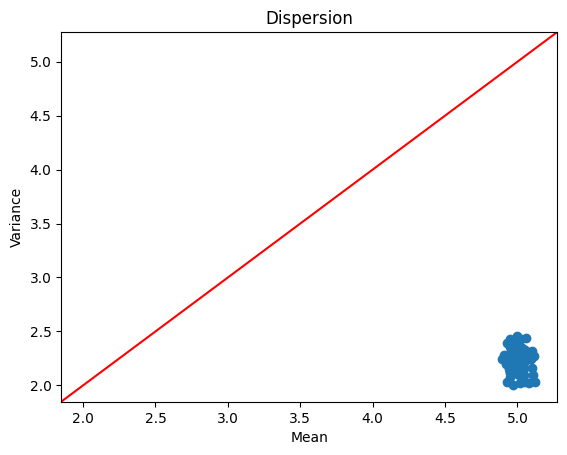

In [42]:
# settings
lam = 5
alp = -0.5
M = 20

# display
plot_dispersion(lam, alp, M, 1000, 100, True)

# sample
data = construct_dispersed_dataset(lam, alp, M, True, 1000, 5)

In [43]:
# optimize moments
constraints = [
    "moment",
    "higher_moment",
    "marginal_CME_1",
    "k_deg_1"
]

opt = optimization.Optimization(data, constraints, tqdm_disable=True)

Optimization status: INFEASIBLE
Runtime: 0.029999971389770508
Optimization status: INFEASIBLE
Runtime: 0.021000146865844727
Optimization status: INFEASIBLE
Runtime: 0.03800010681152344
Optimization status: INFEASIBLE
Runtime: 0.018000125885009766
Optimization status: INFEASIBLE
Runtime: 0.01699995994567871


In [44]:
# optimize probabilities
constraints = [
    "marginal_probability_1",
    "marginal_CME_1",
    "k_deg_1"
]

opt = optimization.Optimization(data, constraints, tqdm_disable=True)

Optimization status: INFEASIBLE
Runtime: 0.003000020980834961
Optimization status: INFEASIBLE
Runtime: 0.006000041961669922
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.006999969482421875


# Higher moments